# Environment Set Up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jsonParser import SmurfsDataset
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim

import random

from pycocotools.coco import COCO

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Loading and Labeling Data

In [3]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "result.json"

num_images = 42
imgs_ids = list(range(num_images))
dataset = SmurfsDataset(data_path, json_file_name, imgs_ids)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def update_annot_cat(dataset):
    print("Category Ids:", dataset.categ_dict)
    
    while True:
        ann_id = input("Enter Annotation Id: ")
    
        if not ann_id.isdigit():
            break
            
        cat_id = input("Enter Category Id: ")
    
        if not cat_id.isdigit():
            break
        
        dataset.set_annot_cat_by_id(int(cat_id), int(ann_id))
        dataset.update_json_cat_by_ann_id(int(cat_id), int(ann_id))
        print(f'Annotation ID {ann_id} with new category id {cat_id}')
    
        print("-------------")

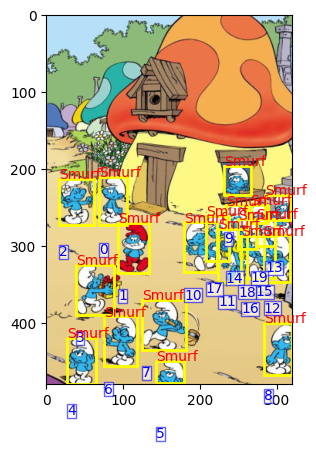

In [5]:
dataset.visualize_annot_by_imgid(0)

In [6]:
# update_annot_cat(dataset)

# Preprocessing Data

## Train - Test Split

In [7]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "updated_result.json"

num_images = 42
imgs_ids = list(range(num_images))

train_images = int(num_images*0.8)
test_images = num_images - train_images

train_ids = random.sample(imgs_ids,train_images)
test_ids = list(set(imgs_ids) - set(train_ids))


train_dataset = SmurfsDataset(data_path, json_file_name, train_ids)
test_dataset = SmurfsDataset(data_path, json_file_name, test_ids)


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


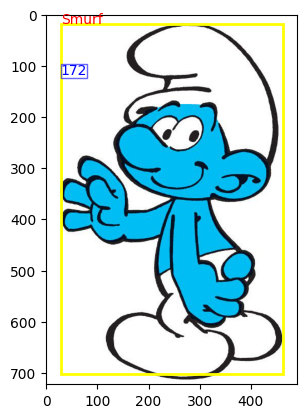

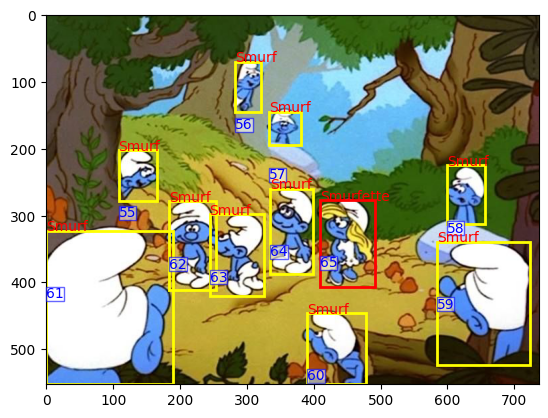

In [8]:
train_dataset.visualize_annot_by_imgid(29)
test_dataset.visualize_annot_by_imgid(0)

# Training Code

In [13]:
# Creating the DataLoader
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

#Instanciating the model with the Loss function and Optimizer
num_classes = 4
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", 
                 in_channels=3, classes=num_classes)
preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [14]:
#To make sure the encoder weights do not get updated as it has been training with a large amount of data from imagenet
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
# Training loop
num_epochs = 10
freeze_encoder(model)
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch['image']
        target_masks = batch['target']

        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure the network output has the same number of channels as classes
        # Apply softmax activation along the channel dimension
        predictions = nn.functional.softmax(outputs, dim=1)
        # predictions = (predictions > 0.6).float().requires_grad_()

        # Flatten predictions and target masks
        predictions = predictions.view(-1, num_classes)
        target_masks = target_masks.view(-1, num_classes)

        loss = criterion(predictions, target_masks)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


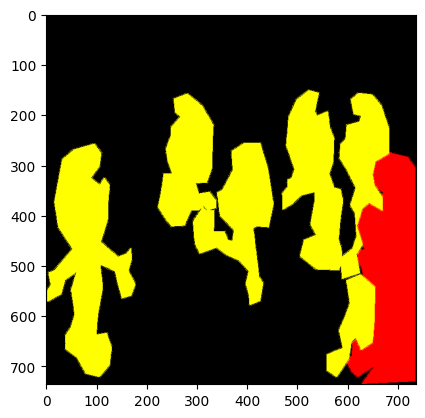

In [152]:
rgb_mask = train_dataset.generate_multi_class_mask(torch.reshape(target_masks,(4,736,736)).detach().numpy())

plt.figure()
plt.imshow(rgb_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


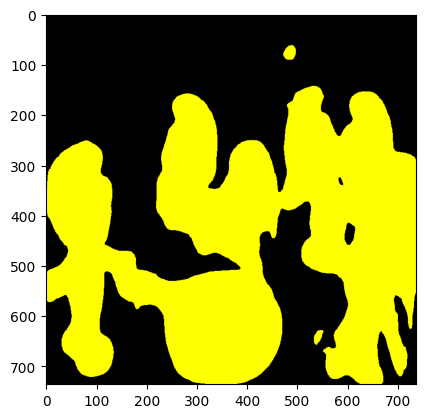

In [153]:
bin_pred = (predictions > 0.6).float()
rgb_mask = train_dataset.generate_multi_class_mask(torch.reshape(bin_pred,(4,736,736)).detach().numpy())

plt.figure()
plt.imshow(rgb_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


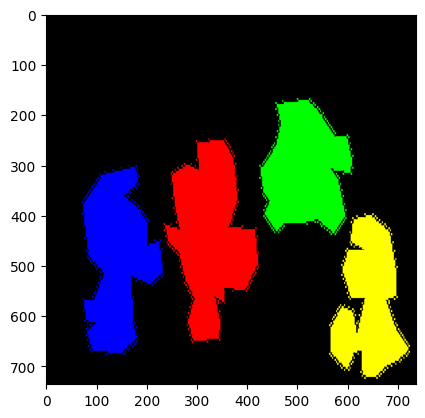

In [126]:
rgb_mask = train_dataset.generate_multi_class_mask(train_dataset.__getitem__(29)['target'].numpy())

plt.figure()
plt.imshow(rgb_mask)

torch.Size([3, 736, 736])


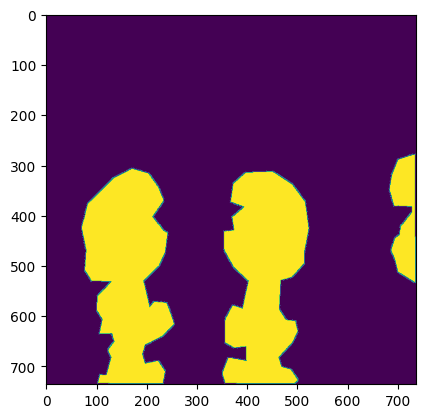

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = train_dataset.__getitem__(10)['target']
plt.figure()
plt.imshow(mask[0,:,:])